In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('charity_navigator_clean.csv', index_col = 0)

In [3]:
n = 0
for excess_or_deficit in df['excess_or_deficit_for_year']:
    if df.loc[n, 'excess_or_deficit_for_year'] > 0:
        df.loc[n, 'excess_or_deficit_id'] = str(1)
        n += 1
    elif df.loc[n, 'excess_or_deficit_for_year'] <= 0:
        df.loc[n, 'excess_or_deficit_id'] = str(0)
        n += 1

In [4]:
df2 = df[df['comp_leader_income'].isnull() == False]
org_type_dummies = pd.get_dummies(df2.org_type)
df2 = pd.concat([df2, org_type_dummies], axis=1, join = 'outer')
df2.drop(['charity_name', 'charity_url', 
          'city', 'cn_advisory', 
          'state', 'org_type',
          'org_category', 'comp_leader_title'], 
         axis = 1, inplace = True)
df2.head()

,accountability_score,administrative_expenses,comp_leader_income,comp_leader_expense_pct,excess_or_deficit_for_year,financial_score,fundraising_expenses,net_assets,other_revenue,overall_score,...,"Arts, Culture, Humanities",Community Development,Education,Environment,Health,Human Services,Human and Civil Rights,International,Religion,Research and Public Policy
0,89.0,164590.0,53463.0,3.11,349718.0,90.56,111522,1350382,49634.0,89.75,...,0,0,0,0,0,0,1,0,0,0
1,86.0,1001560.0,73500.0,1.47,1175965.0,85.92,54613,14773920,382540.0,85.95,...,0,0,1,0,0,0,0,0,0,0
2,85.0,93957.0,85000.0,0.99,-461502.0,77.65,248833,-770370,0.0,80.96,...,0,0,0,0,0,0,0,1,0,0
3,86.0,346867.0,61220.0,0.78,1872733.0,97.50,384550,11460087,-81726.0,89.94,...,0,0,1,0,0,0,0,0,0,0
4,97.0,135195.0,74244.0,5.41,-103940.0,87.08,87436,723772,32436.0,90.62,...,0,0,0,0,0,0,0,0,1,0


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree
from sklearn import metrics

In [6]:
X = df2[['accountability_score', 'financial_score',
         'overall_score', 'administrative_expenses',
         'fundraising_expenses', 'net_assets',
         'other_revenue', 'payments_to_affiliates',
         'comp_leader_income', 'comp_leader_expense_pct',
         'Animals', 'Arts, Culture, Humanities',
         'Community Development', 'Education',
         'Environment', 'Health', 'Human Services',
         'Human and Civil Rights', 'International',
         'Religion']]
y = df2['excess_or_deficit_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 101)

In [7]:
scores = []

for m in range(1, 40):
    dtree = DecisionTreeClassifier(max_depth = m)
    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)
    scores.append(dtree.score(X_test, y_test))

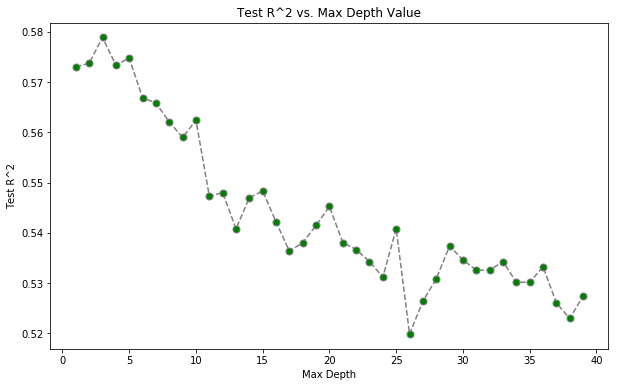

In [8]:
plt.figure(figsize = (10, 6))

plt.plot(range(1, 40), scores, color = 'grey', 
         linestyle = 'dashed', marker = 'o',
         markerfacecolor = 'green', markersize = 7)
plt.title('Test R^2 vs. Max Depth Value')
plt.xlabel('Max Depth')
plt.ylabel('Test R^2');

In [9]:
dtree = DecisionTreeClassifier(max_depth = 3)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

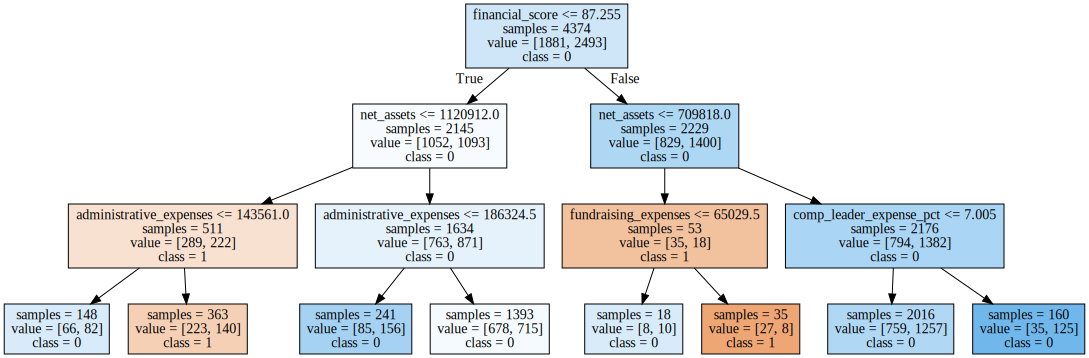

In [10]:
plot_decision_tree(dtree, X.columns, y.unique())

In [11]:
dtree_dict = {}
n = 0
for feature_importances in dtree.feature_importances_:
    dtree_dict[X.columns[n]] = dtree.feature_importances_[n]
    n += 1
    
dtree_df = pd.Series(dtree_dict).to_frame()
dtree_df.rename({0: 'feature_importance'}, axis = 'columns', inplace = True)

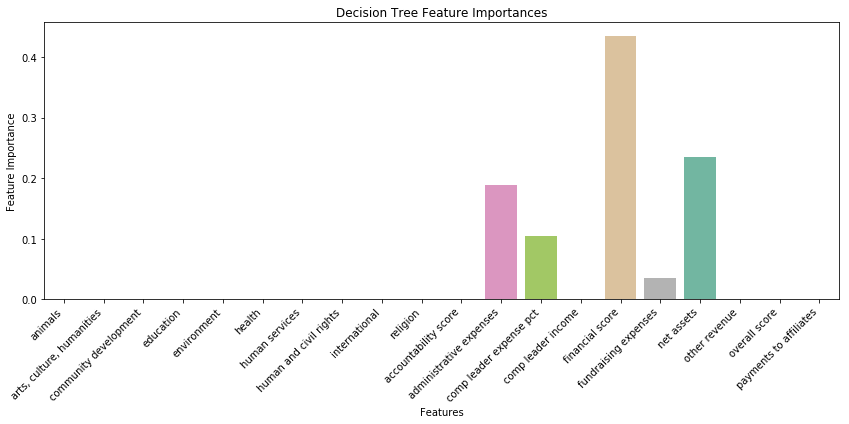

In [12]:
plt.figure(figsize = (12, 6))

ax = sns.barplot(x = dtree_df.index, 
                 y = dtree_df['feature_importance'], 
                 data = dtree_df, palette = 'Set2')
ax.set_xlabel('Features')
ax.set_ylabel('Feature Importance')
ax.set_title('Decision Tree Feature Importances')
ax.set_xticklabels(dtree_df.index.str.lower().str.replace('_', ' '), 
                   rotation = 45, ha = "right")

plt.tight_layout()

In [13]:
print('Train R^2:', dtree.score(X_train, y_train).round(4))
print('Test  R^2:', dtree.score(X_test, y_test).round(4))
print('MAE:      ', metrics.mean_absolute_error(y_test, y_pred).round(4))
print('MSE:      ', metrics.mean_squared_error(y_test, y_pred).round(4))
print('RMSE:     ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(4))

Train R^2: 0.5933
Test  R^2: 0.5789
MAE:       0.4211
MSE:       0.4211
RMSE:      0.6489


In [14]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.54      0.10      0.16      1245
          1       0.58      0.94      0.72      1671

avg / total       0.56      0.58      0.48      2916

[[ 120 1125]
 [ 103 1568]]


In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rfc = RandomForestClassifier(n_estimators = 600)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [17]:
print('Train R^2:', rfc.score(X_train, y_train).round(4))
print('Test  R^2:', rfc.score(X_test, y_test).round(4))
print('MAE:      ', metrics.mean_absolute_error(y_test, y_pred).round(4))
print('MSE:      ', metrics.mean_squared_error(y_test, y_pred).round(4))
print('RMSE:     ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(4))

Train R^2: 1.0
Test  R^2: 0.573
MAE:       0.427
MSE:       0.427
RMSE:      0.6534


In [18]:
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.50      0.34      0.40      1245
          1       0.60      0.75      0.67      1671

avg / total       0.56      0.57      0.56      2916

[[ 423  822]
 [ 423 1248]]
